This Notebook provides a minimal example for using LFP to train a simple LeNet on MNIST.

For more complex examples, refer to the experiment notebooks in ./nbs

### Imports

In [1]:
import os
import joblib
import random

import numpy as np
import torch
import torch.nn as tnn
import torcheval.metrics
import torchvision.datasets as tvisiondata
import torchvision.transforms as T
from tqdm import tqdm

from lfprop.model.models import ACTIVATION_MAP

from lfprop.propagation import (
    propagator_lxt as propagator,
)  # LFP propagator.
from lfprop.rewards import reward_functions as rewards  # Reward Functions
from lfprop.rewards import rewards as loss_fns

/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [2]:
model_name = "mlp" #lenet
optimizer_name = "sgd"
data_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/mnist/"  # Path to your dataset
savepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/tmp" # Path to save results
os.makedirs(savepath, exist_ok=True)

batch_size = 128
n_channels = 1
n_outputs = 10

lr = 0.1
momentum = 0.9
epochs = 2

seed = 0

def set_random_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Dataset

In [3]:
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
training_data = tvisiondata.MNIST(
    root=data_path,
    transform=transform,
    download=True,
    train=True,
)

testing_data = tvisiondata.MNIST(
    root=data_path,
    transform=transform,
    download=True,
    train=False,
)

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False)

In [4]:
apply_noises = [True, False]
noise_sizes = [0.1]#, 0.5, 0.01]
propagator_names = ["lfp-epsilon", "vanilla-gradient"]

model_dict = {
    prop_name: {
        True: {
            noise_size: [] for noise_size in noise_sizes
        },
        False: {1.0: []},
    } for prop_name in propagator_names
}

### Load Model

In [5]:
class NoisyWrapper(tnn.Module):
    def __init__(self, module, noise_size, apply_noise, *args, **kwargs):
        super().__init__()
        
        self.noise_size = noise_size
        self.apply_noise = apply_noise
        self.module = module
        self.zeros_ratio = 0
        
    def forward(self, x):
        self.zeros_ratio = ((x==0).sum()/x.numel()).item()
        if self.training and self.apply_noise:
            noise = torch.randn_like(x)*self.noise_size
            x = x + noise

        return self.module.forward(x)

class NoisyLeNet(tnn.Module):
    """
    Small LeNet
    """

    def __init__(self, n_channels, n_outputs, noise_size=1e-6, apply_noise=True, activation=tnn.ReLU):
        super().__init__()

        self.noise_size = noise_size
        self.apply_noise = apply_noise

         # Feature extractor
        self.features = tnn.Sequential(
            NoisyWrapper(tnn.Conv2d(n_channels, 16, 5), noise_size, apply_noise),
            activation(),
            tnn.MaxPool2d(2, 2),
            NoisyWrapper(tnn.Conv2d(16, 16, 5), noise_size, apply_noise),
            activation(),
            tnn.MaxPool2d(2, 2),
        )

        # Classifier
        self.classifier = tnn.Sequential(
            NoisyWrapper(tnn.Linear(256 if n_channels == 1 else 400, 120), noise_size, apply_noise),
            activation(),
            tnn.Dropout(),
            NoisyWrapper(tnn.Linear(120, 84), noise_size, apply_noise),
            activation(),
            tnn.Dropout(),
            NoisyWrapper(tnn.Linear(84, n_outputs), noise_size, apply_noise),
        )

    def forward(self, x):
        """
        forwards input through network
        """

        # Forward through network
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        self.zeros_ratio = ((x==0).sum()/x.numel()).item()
        
        # if self.training and self.apply_noise:
        #     noise = torch.randn_like(x)*self.noise_size
        #     x = x + noise

        # Return output
        return x

class NoisyMLP(tnn.Module):
    """
    Small MLP
    """

    def __init__(self, n_channels, n_outputs, noise_size=1e-6, apply_noise=True, activation=tnn.ReLU):
        super().__init__()

        self.noise_size = noise_size
        self.apply_noise = apply_noise

        # Classifier
        self.classifier = tnn.Sequential(
            NoisyWrapper(tnn.Linear(28*28, 120), noise_size, apply_noise),
            activation(),
            NoisyWrapper(tnn.Linear(120, 84), noise_size, apply_noise),
            activation(),
            NoisyWrapper(tnn.Linear(84, n_outputs), noise_size, apply_noise),
            activation(),
        )

    def forward(self, x):
        """
        forwards input through network
        """

        # Forward through network
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        self.zeros_ratio = ((x==0).sum()/x.numel()).item()
        
        if self.training and self.apply_noise:
            noise = torch.randn_like(x)*self.noise_size
            x = x + noise

        # Return output
        return x

def name_modules(module, name):
    """
    Recursive function to name modules for debugging 
    """
    
    for cname, child in module.named_children():
        child.tmpname = cname if name == "" else f"{name}.{cname}"
        name_modules(child, child.tmpname)

for propagator_name in propagator_names:
    for apply_noise in model_dict[propagator_name].keys():
        for noise_size in model_dict[propagator_name][apply_noise].keys():
            
            set_random_seeds(seed)

            if model_name == "mlp":
                model_class = NoisyMLP
            elif model_name == "lenet":
                model_class = NoisyLeNet
            else:
                raise ValueError
            
            model = model_class(
                noise_size=noise_size,
                apply_noise=apply_noise,
                n_channels=n_channels,
                n_outputs=n_outputs,
                activation=ACTIVATION_MAP["step"]
            )

            name_modules(model, "")
            model.tmpname = "root"
            model.to(device)
            model.eval()
            print(propagator_name, apply_noise, noise_size, model)
            model_dict[propagator_name][apply_noise][noise_size].append(model)

lfp-epsilon True 0.1 NoisyMLP(
  (classifier): Sequential(
    (0): NoisyWrapper(
      (module): Linear(in_features=784, out_features=120, bias=True)
    )
    (1): Step()
    (2): NoisyWrapper(
      (module): Linear(in_features=120, out_features=84, bias=True)
    )
    (3): Step()
    (4): NoisyWrapper(
      (module): Linear(in_features=84, out_features=10, bias=True)
    )
    (5): Step()
  )
)
lfp-epsilon False 1.0 NoisyMLP(
  (classifier): Sequential(
    (0): NoisyWrapper(
      (module): Linear(in_features=784, out_features=120, bias=True)
    )
    (1): Step()
    (2): NoisyWrapper(
      (module): Linear(in_features=120, out_features=84, bias=True)
    )
    (3): Step()
    (4): NoisyWrapper(
      (module): Linear(in_features=84, out_features=10, bias=True)
    )
    (5): Step()
  )
)
vanilla-gradient True 0.1 NoisyMLP(
  (classifier): Sequential(
    (0): NoisyWrapper(
      (module): Linear(in_features=784, out_features=120, bias=True)
    )
    (1): Step()
    (2): Nois

### Set Up LFP

In [6]:
# Initialize the LFP Composite
# Currently, only LFP-Epsilon is implemented. More composites may be added in the future.
propagation_composite = propagator.LFPEpsilonComposite()

for propagator_name in propagator_names:
    for apply_noise in model_dict[propagator_name].keys():
        for noise_size in model_dict[propagator_name][apply_noise].keys():
            if propagator_name == "lfp-epsilon":
                propagation_composite = propagator.LFPEpsilonComposite()
                criterion_func = rewards.SoftmaxLossReward(device)
            else:
                propagation_composite = None
                criterion_func = loss_fns.CustomCrossEntropyLoss()
            model_dict[propagator_name][apply_noise][noise_size].append(propagation_composite)
            model_dict[propagator_name][apply_noise][noise_size].append(criterion_func)

# Initialize the Reward Function.
# Here we use the Reward Function suggested in the LFP-Paper, but check out other reward functions in ./lfp/rewards/criterion_functions.py
criterion_func = rewards.SoftmaxLossReward(device)

# LFP writes its updates into the .grad attribute of the model parameters, and can thus utilize standard torch optimizers
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for propagator_name in propagator_names:
    for apply_noise in model_dict[propagator_name].keys():
        for noise_size in model_dict[propagator_name][apply_noise].keys():
            if optimizer_name == "sgd":
                optimizer = torch.optim.SGD(model_dict[propagator_name][apply_noise][noise_size][0].parameters(), lr=lr, momentum=momentum)
            else:
                optimizer = torch.optim.AdamW(model_dict[propagator_name][apply_noise][noise_size][0].parameters(), lr=lr)
            model_dict[propagator_name][apply_noise][noise_size].append(optimizer)

### Set Up Simple Evaluation using torcheval

In [7]:
def eval_model(model, loader, criterion_func):
    """
    Evaluates the model on a single dataset
    """
    eval_metrics = {
        "reward": torcheval.metrics.Mean(device=device),
        "accuracy": torcheval.metrics.MulticlassAccuracy(average="micro", num_classes=10, k=1, device=device),
    }

    model.eval()

    # Iterate over Data Loader
    for index, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            # Get model predictions
            outputs = model(inputs)

        with torch.set_grad_enabled(True):
            # Get rewards
            reward = criterion_func(outputs, labels)

        for k, v in eval_metrics.items():
            if k == "reward":
                eval_metrics[k].update(reward)
            else:
                eval_metrics[k].update(outputs, labels)

    return_dict = {m: metric.compute().detach().cpu().numpy() for m, metric in eval_metrics.items()}

    # Return evaluation
    return return_dict

### Training Loop

In [8]:
def lfp_step(model, optimizer, criterion_func, propagation_composite, inputs, labels):
    """
    Performs a single training step using LFP. This is quite similar to a standard gradient descent training loop.
    """
    # Set Model to training mode
    model.train()

    with torch.enable_grad():
        # Zero Optimizer
        optimizer.zero_grad()

        # This applies LFP
        with propagation_composite.context(model) as modified:
            inputs = inputs.detach().requires_grad_(True)
            outputs = modified(inputs)

            # Calculate reward
            # Do like this to avoid tensors being kept in memory
            reward = torch.from_numpy(criterion_func(outputs, labels).detach().cpu().numpy()).to(device)

            # Calculate LFP and write into .feedback attribute of parameters
            torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]

            # Write LFP Values into .grad attributes. Note the negative sign: LFP requires maximization instead of minimization like gradient descent
            for name, param in model.named_parameters():
                param.grad = -param.feedback

            # Update Clipping. Training may become unstable otherwise, especially in small models with large learning rates.
            # In larger models (e.g., VGG, ResNet), where smaller learning rates are generally utilized, not clipping updates may result in better performance.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0, 2.0)

            # Optimization step
            optimizer.step()

    # Set Model back to eval mode
    model.eval()
    
def grad_step(model, optimizer, criterion_func, inputs, labels):
    """
    Performs a single training step using Gradient Descent
    """
    # Set Model to training mode
    model.train()

    with torch.enable_grad():
        # Zero Optimizer
        optimizer.zero_grad()
            
        inputs = inputs.detach()
        outputs = model(inputs)

        # Calculate reward
        # Do like this to avoid tensors being kept in memory
        loss = criterion_func(outputs, labels)
        loss.backward()

        # Update Clipping. Training may become unstable otherwise, especially in small models with large learning rates.
        # In larger models (e.g., VGG, ResNet), where smaller learning rates are generally utilized, not clipping updates may result in better performance.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0, 2.0)

        # Optimization step
        optimizer.step()

    # Set Model back to eval mode
    model.eval()


# Training Loop
def train(model, optimizer, criterion_func, propagation_composite):
    
    evals = {
        "train_accuracy": [],
        "train_reward": [],
        "test_accuracy": [],
        "test_reward": [],
    }
    
    eval_stats_train = eval_model(model, training_loader, criterion_func)
    eval_stats_test = eval_model(model, testing_loader, criterion_func)
    print(
        "INIT: (Train Reward) {:.2f}; (Train Accuracy) {:.2f}; (Val Reward) {:.2f}; (Val Accuracy) {:.2f}".format(
            float(np.mean(eval_stats_train["reward"])),
            float(eval_stats_train["accuracy"]),
            float(np.mean(eval_stats_test["reward"])),
            float(eval_stats_test["accuracy"]),
        )
    )

    for epoch in range(epochs):
        with tqdm(total=len(training_loader), disable=True) as pbar:
            # Iterate over Data Loader
            for index, (inputs, labels) in enumerate(training_loader):
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                # Perform Update Step
                if propagation_composite is not None:
                    lfp_step(model, optimizer, criterion_func, propagation_composite, inputs, labels)
                else:
                    grad_step(model, optimizer, criterion_func, inputs, labels)
                
                # Log zero ratios
                for cname, child in model.named_modules():
                    if hasattr(child, "zeros_ratio"):
                        if f"zeros_{child.tmpname}" not in evals.keys():
                            evals[f"zeros_{child.tmpname}"] = []
                        evals[f"zeros_{child.tmpname}"].append(child.zeros_ratio)

                # Update Progress Bar
                pbar.update(1)

        # Evaluate and print performance after every epoch
        eval_stats_train = eval_model(model, training_loader, criterion_func)
        eval_stats_test = eval_model(model, testing_loader, criterion_func)
        print(
            "Epoch {}/{}: (Train Reward) {:.2f}; (Train Accuracy) {:.2f}; (Val Reward) {:.2f}; (Val Accuracy) {:.2f}".format(
                epoch + 1,
                epochs,
                float(np.mean(eval_stats_train["reward"])),
                float(eval_stats_train["accuracy"]),
                float(np.mean(eval_stats_test["reward"])),
                float(eval_stats_test["accuracy"]),
            )
        )

        evals["train_accuracy"].append(float(eval_stats_train["accuracy"]))
        evals["train_reward"].append(float(eval_stats_train["reward"]))
        evals["test_accuracy"].append(float(eval_stats_test["accuracy"]))
        evals["test_reward"].append(float(eval_stats_test["reward"]))
        
    return evals

result_dict = {}
result_path = os.path.join(savepath, "result_dict.joblib")
if not os.path.exists(result_path):
    for propagator_name in propagator_names:
        result_dict[propagator_name] = {}
        for apply_noise in model_dict[propagator_name].keys():
            result_dict[propagator_name][apply_noise] = {}
            for noise_size in model_dict[propagator_name][apply_noise].keys():
                eval_single_path = os.path.join(savepath, f"evals_{propagator_name}-{apply_noise}-{noise_size}.joblib")
                if not os.path.exists(eval_single_path):
                    print(f"TRAINING propagator {propagator_name}, apply_noise {apply_noise}, noise_size {noise_size}")
                    evals = train(model_dict[propagator_name][apply_noise][noise_size][0], model_dict[propagator_name][apply_noise][noise_size][3], model_dict[propagator_name][apply_noise][noise_size][2], model_dict[propagator_name][apply_noise][noise_size][1])
                    joblib.dump(evals, eval_single_path)
                else:
                    evals = joblib.load(eval_single_path)
                result_dict[propagator_name][apply_noise][noise_size] = evals
    joblib.dump(result_dict, result_path)
else:
    result_dict = joblib.load(result_path)

TRAINING propagator lfp-epsilon, apply_noise True, noise_size 0.1


/tmp/ipykernel_1556030/1153122503.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


INIT: (Train Reward) -0.02; (Train Accuracy) 0.10; (Val Reward) -0.02; (Val Accuracy) 0.10


/tmp/ipykernel_1556030/1677853771.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/lxt/core.py:362: UserWarning: This functionality is not yet fully tested. Please check the model after removing the composite.
  warn(


Epoch 1/2: (Train Reward) -0.01; (Train Accuracy) 0.11; (Val Reward) -0.01; (Val Accuracy) 0.11


Epoch 2/2: (Train Reward) 0.00; (Train Accuracy) 0.10; (Val Reward) 0.00; (Val Accuracy) 0.10
TRAINING propagator lfp-epsilon, apply_noise False, noise_size 1.0
INIT: (Train Reward) -0.02; (Train Accuracy) 0.10; (Val Reward) -0.02; (Val Accuracy) 0.10


Epoch 1/2: (Train Reward) 0.00; (Train Accuracy) 0.10; (Val Reward) 0.00; (Val Accuracy) 0.10


Epoch 2/2: (Train Reward) 0.00; (Train Accuracy) 0.10; (Val Reward) 0.00; (Val Accuracy) 0.10
TRAINING propagator vanilla-gradient, apply_noise True, noise_size 0.1
INIT: (Train Reward) 2.42; (Train Accuracy) 0.10; (Val Reward) 2.41; (Val Accuracy) 0.10
Epoch 1/2: (Train Reward) 2.42; (Train Accuracy) 0.10; (Val Reward) 2.41; (Val Accuracy) 0.10
Epoch 2/2: (Train Reward) 2.42; (Train Accuracy) 0.10; (Val Reward) 2.41; (Val Accuracy) 0.10
TRAINING propagator vanilla-gradient, apply_noise False, noise_size 1.0
INIT: (Train Reward) 2.42; (Train Accuracy) 0.10; (Val Reward) 2.41; (Val Accuracy) 0.10
Epoch 1/2: (Train Reward) 2.42; (Train Accuracy) 0.10; (Val Reward) 2.41; (Val Accuracy) 0.10
Epoch 2/2: (Train Reward) 2.42; (Train Accuracy) 0.10; (Val Reward) 2.41; (Val Accuracy) 0.10


### Plots

/tmp/ipykernel_1556030/3176988646.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


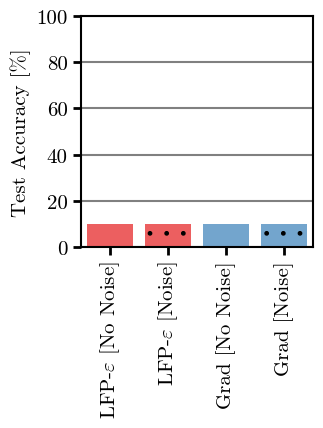

/tmp/ipykernel_1556030/3176988646.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


zeros_root


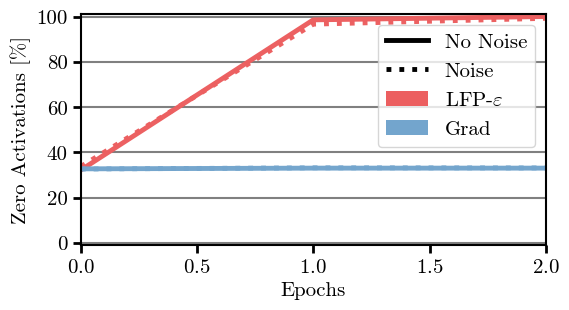

zeros_classifier.0


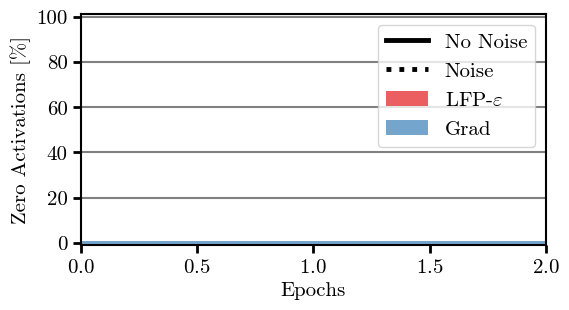

zeros_classifier.2


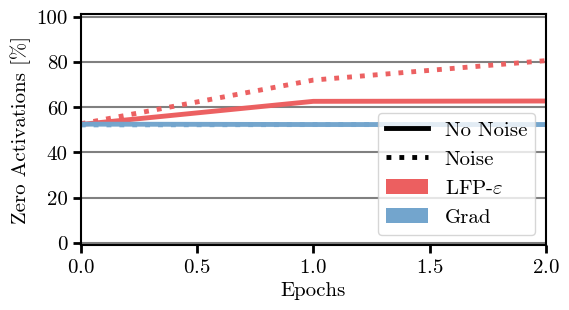

zeros_classifier.4


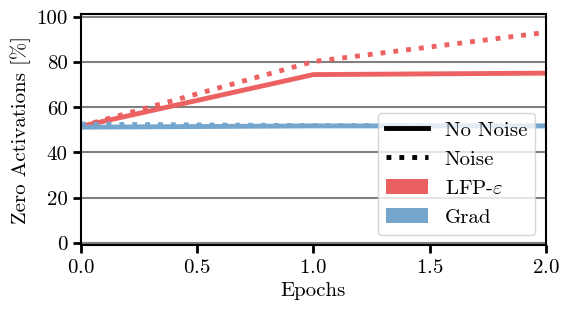

In [9]:
# Plot Settings
# Set font properties.
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.cm as cm
import copy
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

def generate_noise_label(apply_noise, noise_size):
    
    HATCHES = {
        0.1: ".",
        0.2: "x",
    }
    
    LINESTYLES = {
        0.1: "dotted",
        0.2: "dashed",
    }   
    
    MARKERSTYLES = {
        0.1: "D",
        0.2: "x",
    }   
    
    if not apply_noise:
        label = "No Noise"
        hatch = None
        linestyle = "solid"
        markerstyle = "."
        return label, hatch, linestyle, markerstyle
    else:
        label = f"Noise"# " + r"$\sigma=$" + f"{noise_size}"
        hatch = HATCHES[noise_size]
        linestyle = LINESTYLES[noise_size]
        markerstyle = MARKERSTYLES[noise_size]
        return label, hatch, linestyle, markerstyle

def plot_accs(eval_stats, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))
    
    METHOD_LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
    }

    barloc = 0.5
    xlabels = []
    for p, (prop_name, p_data) in enumerate(eval_stats.items()):
        for apply_noise in [False, True]:
            a_data = p_data[apply_noise]
            for noise_size, n_data in a_data.items():
                accuracy = n_data["test_accuracy"][-1]
                label, hatch, linestyle, markerstyle = generate_noise_label(apply_noise, noise_size)
        
                ax.bar(barloc, accuracy, color=palette[p], hatch=hatch)
                xlabels.append(f"{METHOD_LABELS[prop_name]} [{label}]")
                barloc += 1
        
    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(linelocs, xmin=-1, xmax=400, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0, barloc-0.5])

    ax.set_ylabel(f"Test Accuracy [%]")
    ax.set_xlabel("")

    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])

    ax.set_xticks(np.arange(0.5, barloc-0.5, 1.0))
    ax.set_xticklabels(xlabels, rotation=90)

    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

def plot_zero_acts(eval_stats, fname, colormap="Set1", layer_name="root"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))
    
    METHOD_LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
    }

    batches_per_epoch = len(training_loader)

    for p, (prop_name, p_data) in enumerate(eval_stats.items()):
        for apply_noise, a_data in p_data.items():
            for noise_size, n_data in a_data.items():
                zero_acts = [n_data[key] for key in n_data.keys() if layer_name == key]
                zero_acts = np.mean(zero_acts, axis=0)
                zero_acts = [zero_acts[0]] + [np.mean(zero_acts[i*batches_per_epoch:i*batches_per_epoch+batches_per_epoch]) for i in range(epochs)] # Average per epoch
                zero_acts = zero_acts[:50] # first 50 only
                label, hatch, linestyle, markerstyle = generate_noise_label(apply_noise, noise_size)
        
                xaxis = np.arange(0, len(zero_acts))
                ax.plot(xaxis, zero_acts, color=palette[p], label=None, linestyle=linestyle, linewidth=3.5, alpha=.99)
        
    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    for p, prop_name in enumerate(propagator_names):
        label = METHOD_LABELS[prop_name]
        ax.bar(-1, 1, color=palette[p], label=label, alpha=1)
    for apply_noise in [False, True]:
        for noise_size in noise_sizes:
            label, hatch, linestyle, markerstyle = generate_noise_label(apply_noise, noise_size)
            ax.plot([-1, -2], [-1, -1], color="black", label=label, linestyle=linestyle, linewidth=3.5, alpha=1)

    ax.set_ylabel(f"Zero Activations [%]")
    ax.set_xlabel("Epochs")
    ax.set_ylim([-0.01, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim([0.0, xaxis[-1]])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 200])
    ax.legend()
    plt.show()
    fig.savefig(fname)

plot_accs(result_dict, os.path.join(savepath, "test_accuracies.svg"), colormap="Set1")

layer_names = [key for key in result_dict["lfp-epsilon"][False][1.0].keys() if "accuracy" not in key and "reward" not in key]
for layer_name in layer_names:
    print(layer_name)
    plot_zero_acts(result_dict, os.path.join(savepath, f"zero_acts_{layer_name}.svg"), colormap="Set1", layer_name=layer_name)